# LSTM

In [1]:
import pandas as pd
import numpy as np
import math
import sklearn
from tensorflow import keras
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
tf.random.set_seed(8)

#### Define functions

In [3]:
# Imports data (daily or non-daily)
def import_function(daily):
    if daily == True:
        data = pd.read_excel('master_thesis_data_daily.xlsx', index_col=[0])
        y    = data.NO_folio_rate
        data.drop(['NO_folio_publication_date', 'NO_folio_rate'], axis=1, inplace=True)
    else:
        data = pd.read_excel('master_thesis_data.xlsx', index_col=[0])
        y    = data.NO_folio_publication_date
        data.drop('NO_folio_publication_date', axis=1, inplace=True)
    
    return data, y

# Shifts y to make predictions x periods ahead
def periods(data, y, periods):
    y_name = y.name
    y_temp = y.pct_change(periods).replace(np.nan, 0)
    temp   = pd.concat([y_temp.shift(-periods + 1).dropna(), data], join='inner', axis=1)
    y      = temp[y_name]
    temp.drop(y_name, axis=1, inplace=True)
    
    return temp, y

# Splits data into train and test 
def TT_split(x, y, daily, test_pct):
    if test_pct == 'fixed':
        if daily == True: split = 4507
        else: split = 128
    else:   
        split = int(len(x)*(1-test_pct))

    x_train, x_test = x[:split], x[split:]
    y_train, y_test = y[:split], y[split:]

    return x_train, x_test, y_train, y_test

# Normalizes x-variables based on x_train scales
def mm_normalize(x_train, x_test):
    scaler  = MinMaxScaler(feature_range=(0, 1)).fit(x_train)
    x_train = scaler.transform(x_train)
    x_test  = scaler.transform(x_test)
    
    return x_train, x_test

In [4]:
# Defining a LSTM-model
def LSTM_model(x_train, x_test, y_train, y_test):
    LSTM_mod = keras.models.Sequential()
    LSTM_mod.add(keras.layers.LSTM(200, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
    LSTM_mod.add(keras.layers.LSTM(100, activation='relu'))
    LSTM_mod.add(keras.layers.Dense(1))
    LSTM_mod.compile(loss='mse', optimizer='adam')

    es = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.00001, patience = 15, restore_best_weights=True)
    history = LSTM_mod.fit(x_train, y_train, batch_size=512, epochs=100, validation_split=0.2, verbose=0, shuffle=False, callbacks=[es])
    
    y_pred     = LSTM_mod.predict(x_test)
    train_pred = LSTM_mod.predict(x_train)
    test_RMSE  = sklearn.metrics.mean_squared_error(y_test, y_pred, squared=False)

    print("Test MSE: %.8f" % test_RMSE)
    
    return y_pred, train_pred, history, test_RMSE

#### Import data

In [5]:
daily       = False
data, folio = import_function(daily=daily)

# Add 1 lag of folio rate and remove NaN
data['folio_lag'] = folio.pct_change().shift(1).replace(np.nan, 0)[2:]
data.dropna(inplace=True)
folio = folio[1:]
split = int(len(folio[1:]) * 0.8)

#### Run model

In [6]:
y_pred, train_pred, history, test_RMSE, ys, ys_train = {}, {}, {}, {}, {}, {}

for period in range(1, 6):
    
    x, y = periods(data, folio, periods=period)
    x_train, x_test = x[:split], x[split:]
    y_train, y_test = y[:split], y[split:]
    x_train, x_test = mm_normalize(x_train, x_test)
    
    x_train, x_test = x_train.reshape(x_train.shape[0], 1, x_train.shape[1]), x_test.reshape(x_test.shape[0], 1, x_test.shape[1])
    y_train, y_test = y_train.values.reshape(y_train.shape[0], 1), y_test.values.reshape(y_test.shape[0], 1)
    
    y_hat, train_hat, historie, RMSE = LSTM_model(x_train, x_test, y_train, y_test)
    
    y_pred    ["y_pred_{0}"    .format(period)] = y_hat
    train_pred["train_pred_{0}".format(period)] = train_hat
    history   ["history_{0}"   .format(period)] = historie
    test_RMSE ["test_RMSE_{0}" .format(period)] = RMSE
    ys        ["ys_test_{0}"   .format(period)] = y_test
    ys_train  ["ys_train_{0}"  .format(period)] = y_train

Test MSE: 0.23721207
Test MSE: 0.30841021
Test MSE: 0.40800165
Test MSE: 0.48191175
Test MSE: 0.57019890


#### Manage results

In [7]:
for key in ys.keys():
    ys[str(key)] = ys[str(key)].reshape(-1).tolist()
    
for key in y_pred.keys():
    y_pred[str(key)] = y_pred[str(key)].reshape(-1).tolist()
    
comb_y_test = pd.DataFrame.from_dict(ys,     orient='index').transpose()
comb_y_pred = pd.DataFrame.from_dict(y_pred, orient='index').transpose()
comb_y_test.index, comb_y_pred.index = folio.index[split+1:], folio.index[split+1:]
comb_y_pred.columns = ['y_oos_pred_0', 'y_oos_pred_1', 'y_oos_pred_2', 'y_oos_pred_3', 'y_oos_pred_4']
comb_y_test.columns = ['y_test_0', 'y_test_1', 'y_test_2', 'y_test_3', 'y_test_4']

for i in range(5):
    comb_y_test.iloc[:, i] = folio[split-1:].shift(1).dropna() * (comb_y_test.iloc[:, i] + 1)
    comb_y_pred.iloc[:, i] = folio[split-1:].shift(1).dropna() * (comb_y_pred.iloc[:, i] + 1)

NB = pd.read_excel('Styringsrenter_sammensatt.xlsx', index_col=[1])
NB.drop('Quarter', axis=1, inplace=True)
NB.drop(NB.iloc[:, 5:], axis=1, inplace=True)
NB.dropna(inplace=True)
NB = NB / 100

comparison = pd.concat([comb_y_test, comb_y_pred, NB], axis=1, join='inner')

#### Plot results

Text(0, 0.5, 'Loss')

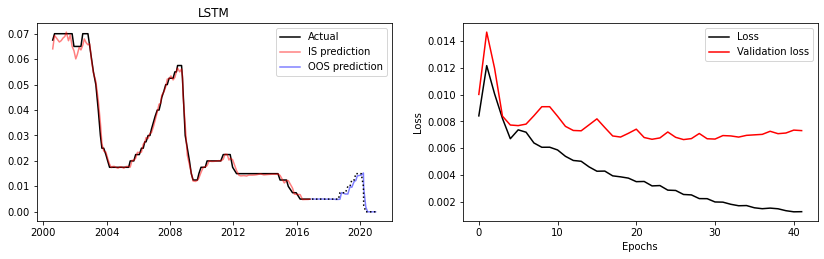

In [8]:
fig = plt.figure(figsize = (14, 8))

plt.subplot2grid((2, 2), (0, 0), colspan = 1, rowspan = 1)
plt.plot(folio.index[1:split+1], (ys_train['ys_train_1'][:split].reshape(-1) + 1) * folio[:split+1].shift(1).dropna(), color = "black", label = "Actual")
plt.plot(folio.index[1:split+1], (train_pred['train_pred_1'].reshape(-1)[:split] + 1) * folio[:split+1].shift(1).dropna(), color = "Red",   alpha = 0.5, label = "IS prediction")
plt.plot(folio.index[split+1:], comb_y_pred['y_oos_pred_0'], color = "Blue",   alpha = 0.5, label = "OOS prediction")
plt.plot(folio.index[split+1:], comb_y_test['y_test_0'], color = "black", linestyle=':')
plt.legend()
plt.title("LSTM")

plt.subplot2grid((2, 2), (0, 1), colspan = 1, rowspan = 1)
plt.plot(history['history_1'].history['loss'], color = "black", label = "Loss")
plt.plot(history['history_1'].history['val_loss'], color = "red", label = "Validation loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")

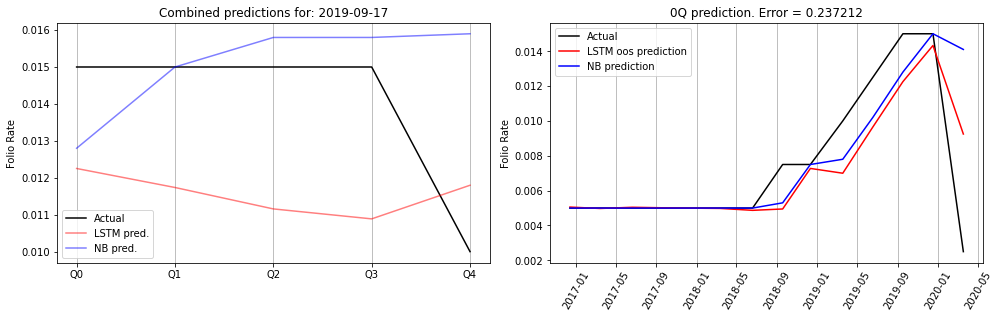

In [9]:
time  = ['Q0', 'Q1', 'Q2', 'Q3', 'Q4']
serie = 11

fig = plt.figure(figsize = (14, 8))

plt.subplot2grid((2, 2), (0, 0), colspan = 1, rowspan = 1)
plt.plot(time, comparison.iloc[serie, :5].values,   color = "black", label = "Actual")
plt.plot(time, comparison.iloc[serie, 5:10].values, color = "red",   alpha = 0.5, label = "LSTM pred.")
plt.plot(time, comparison.iloc[serie, 10:].values,  color = "blue",  alpha = 0.5, label = "NB pred.")
plt.title("Combined predictions for: " + str(comparison.index[serie].date()))
plt.ylabel("Folio Rate")
plt.legend()
plt.grid(axis = 'x')

plt.subplot2grid((2, 2), (0, 1), colspan = 1, rowspan = 1)
plt.plot(comparison.iloc[:, 0],  color= "black", label = "Actual")
plt.plot(comparison.iloc[:, 5],  color= "red",   label = "LSTM oos prediction")
plt.plot(comparison.iloc[:, 10], color= "blue",  label = "NB prediction")
plt.title("0Q prediction. Error = " + str(round(test_RMSE['test_RMSE_1'], 6)))
plt.ylabel("Folio Rate")
plt.xticks(rotation=60)
plt.legend()
plt.grid(axis = 'x')

plt.tight_layout()

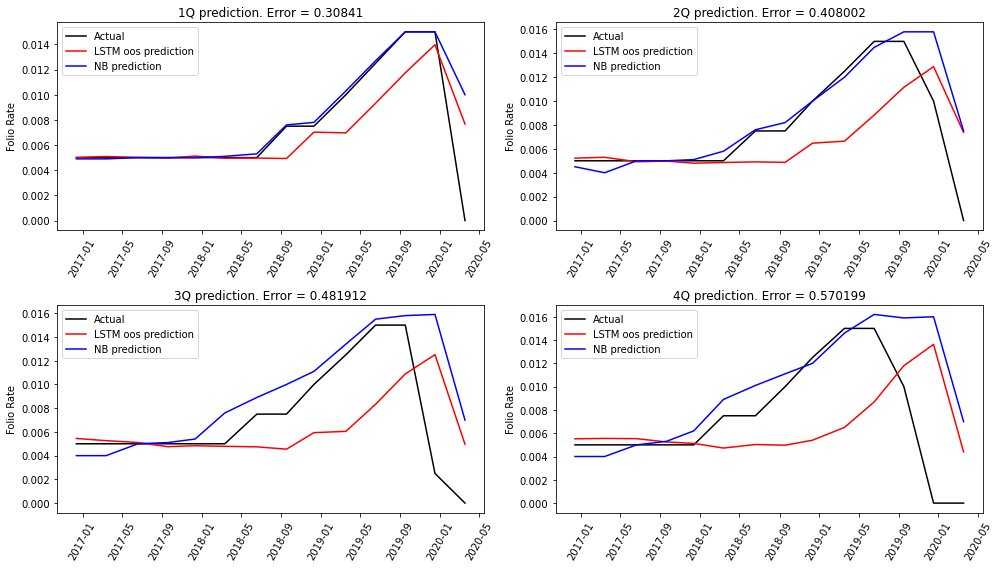

In [10]:
fig = plt.figure(figsize = (14, 8))

plt.subplot2grid((2, 2), (0, 0), colspan = 1, rowspan = 1)
plt.plot(comparison.iloc[:, 1],  color= "black", label = "Actual")
plt.plot(comparison.iloc[:, 6],  color= "red",   label = "LSTM oos prediction")
plt.plot(comparison.iloc[:, 11], color= "blue",  label = "NB prediction")
plt.title("1Q prediction. Error = " + str(round(test_RMSE['test_RMSE_2'], 6)))
plt.ylabel("Folio Rate")
plt.xticks(rotation=60)
plt.legend()

plt.subplot2grid((2, 2), (0, 1), colspan = 1, rowspan = 1)
plt.plot(comparison.iloc[:, 2],  color= "black", label = "Actual")
plt.plot(comparison.iloc[:, 7],  color= "red",   label = "LSTM oos prediction")
plt.plot(comparison.iloc[:, 12], color= "blue",  label = "NB prediction")
plt.title("2Q prediction. Error = " + str(round(test_RMSE['test_RMSE_3'], 6)))
plt.ylabel("Folio Rate")
plt.xticks(rotation=60)
plt.legend()

plt.subplot2grid((2, 2), (1, 0), colspan = 1, rowspan = 1)
plt.plot(comparison.iloc[:, 3],  color= "black", label = "Actual")
plt.plot(comparison.iloc[:, 8],  color= "red",   label = "LSTM oos prediction")
plt.plot(comparison.iloc[:, 13], color= "blue",  label = "NB prediction")
plt.title("3Q prediction. Error = " + str(round(test_RMSE['test_RMSE_4'], 6)))
plt.ylabel("Folio Rate")
plt.xticks(rotation=60)
plt.legend();

plt.subplot2grid((2, 2), (1, 1), colspan = 1, rowspan = 1)
plt.plot(comparison.iloc[:, 4], color= "black", label = "Actual")
plt.plot(comparison.iloc[:, 9], color= "red", label = "LSTM oos prediction")
plt.plot(comparison.iloc[:, 14], color= "blue", label = "NB prediction")
plt.title("4Q prediction. Error = " + str(round(test_RMSE['test_RMSE_5'], 6)))
plt.ylabel("Folio Rate")
plt.xticks(rotation=60)
plt.legend();

plt.tight_layout()

In [11]:
comb_y_pred.to_excel('LSTM_predictions_stationary.xlsx')